In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import seaborn as sns
import scipy
np.set_printoptions(linewidth=np.inf,threshold=np.inf)
pd.set_option('display.max_rows', 30)
pd.set_option('display.min_rows', 30)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [17]:
data_dir = 'C:/Users/luke/GitMath/Selected_Voice_Clips/'
voice_list_filename = "voice_clip_meta_data.csv"
voice_list = pd.read_csv(data_dir + voice_list_filename)
voice_feature = pd.read_csv(data_dir + "voice_feature_20241022.csv")

In [18]:

f0_colnames = []
zcr_colnames = []
mfcc_colnames = ['mfcc_00', 'mfcc_01', 'mfcc_02', 'mfcc_03', 'mfcc_04', 'mfcc_05', 'mfcc_06', 'mfcc_07', 'mfcc_08', 'mfcc_09']
stats_name = ['mean','std','var','min','max','skew','kurtosis']
for x in stats_name :
    f0_colnames.append('f0_'+ x)
for x in stats_name :
    zcr_colnames.append('zcr_'+ x)
for x in range(25) :
    if x > 10 :
        num = str(x)
        mfcc_colnames.append('mfcc_' + num)

In [19]:
# Function to find the optimal k using the Elbow Method
def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:, colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = []
    for k in clusters_range:
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure()
    plt.plot(clusters_range, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters: k')
    plt.ylabel('Inertia')
    plt.show()

    # Return the "elbow" point using the first significant drop heuristic
    differences = np.diff(inertias)
    second_differences = np.diff(differences)
    elbow_point = np.argmax(second_differences) + 2  # +2 due to double differentiation and range shift
    print(f"Optimal k (elbow point): {elbow_point}")
    return elbow_point

# Function to run KMeans clustering
def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:, colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    print(f"KMeans clustering completed with {k} clusters.")
    return df

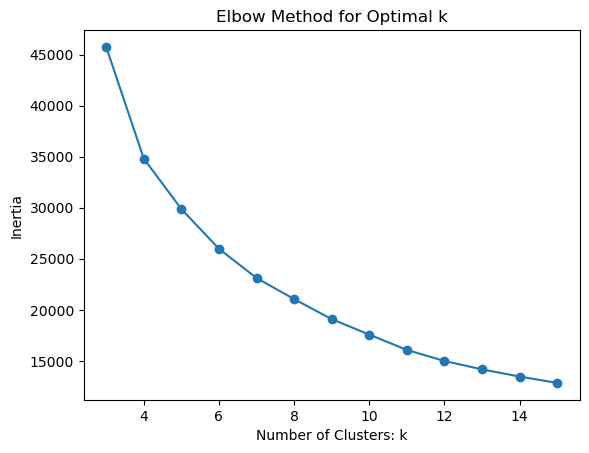

Optimal k (elbow point): 2


2

In [20]:
df = voice_feature.dropna()
colnames = f0_colnames
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames, clusters_range)


In [21]:
k = 2
colnames = ["len_in_second", "sampling_rate","array_size"]
kmeans1 = run_kmeans(voice_feature, colnames,k,)
kmeans1.groupby("cluster").size()

KMeans clustering completed with 2 clusters.


cluster
0    7273
1    9437
dtype: int64

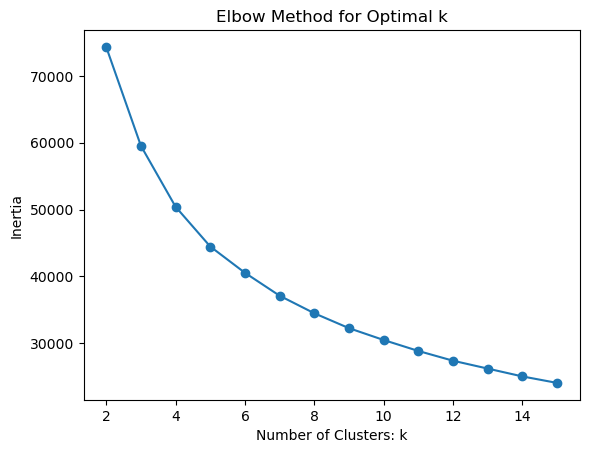

Optimal k (elbow point): 2


2

In [22]:
df = voice_feature
colnames = zcr_colnames
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)


In [23]:
k = 2
colnames = zcr_colnames
kmeans2 = run_kmeans(voice_feature, colnames,k,)
kmeans2.groupby("cluster").size()

KMeans clustering completed with 2 clusters.


cluster
0    7746
1    8964
dtype: int64

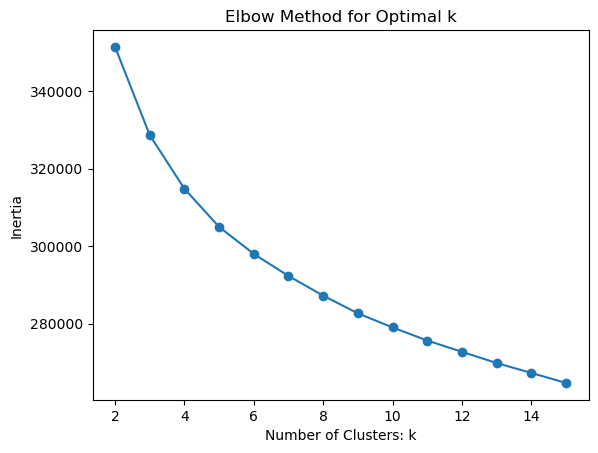

Optimal k (elbow point): 2


2

In [24]:
df = voice_feature
colnames = mfcc_colnames
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)


In [25]:
k = 2
colnames = mfcc_colnames
kmeans3 = run_kmeans(voice_feature, colnames,k,)
kmeans3.groupby("cluster").size()

KMeans clustering completed with 2 clusters.


cluster
0     5828
1    10882
dtype: int64

Initializing the training for other classifiers

In [26]:
voice_features = voice_feature.dropna()
X = voice_features[f0_colnames + mfcc_colnames + zcr_colnames]
X = preprocessing.MinMaxScaler().fit_transform(X)
y = voice_features.gender
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=1)

Random Forest Culstering

0.9370880766926303 [0.93512974 0.94311377 0.93806194 0.94905095 0.93506494 0.93306693 0.94105894 0.94205794 0.94005994 0.93806194]


<Figure size 500x1000 with 0 Axes>

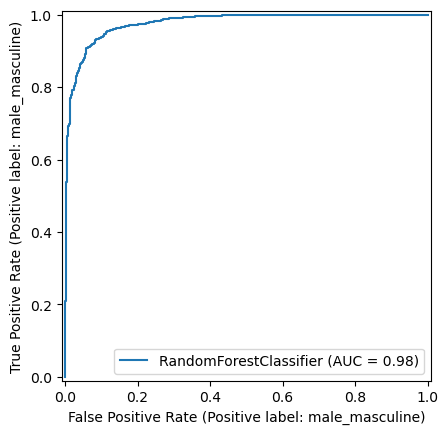

In [27]:
RFC = RandomForestClassifier(criterion= "gini", random_state=0,max_depth=5)
RFC = RFC.fit(X_train, y_train)
RFCscore = RFC.score(X_test, y_test)
CVscore = cross_val_score(RFC, X_train, y_train, cv=10)
print(RFCscore, CVscore)
plt.figure(figsize= (5, 10))
metrics.RocCurveDisplay.from_estimator(RFC, X_test, y_test)

HistGradientBoostingClassifier

0.9571599760335531 [0.96307385 0.96107784 0.96203796 0.96803197 0.96403596 0.95704296 0.96703297 0.96403596 0.97002997 0.96003996]


<Figure size 500x1000 with 0 Axes>

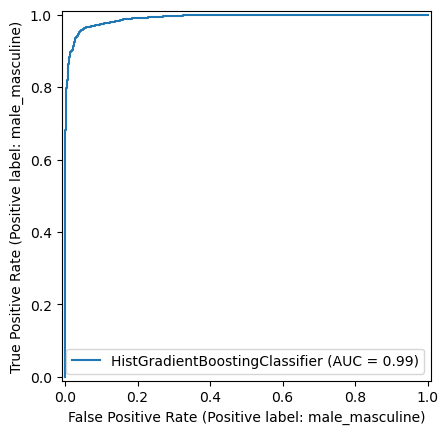

In [28]:
HGBC = HistGradientBoostingClassifier(loss='log_loss', learning_rate=0.1, max_iter=50, max_leaf_nodes=15, max_depth=5, early_stopping='auto', scoring='loss')
HGBC = HGBC.fit(X_train, y_train)
HGBCscore = HGBC.score(X_test, y_test)
CVscore = cross_val_score(HGBC, X_train, y_train, cv = 10)
print(HGBCscore, CVscore)
plt.figure(figsize= (5, 10))
metrics.RocCurveDisplay.from_estimator(HGBC, X_test, y_test)